# Jupyter notebook for debugging

In [17]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml
import matplotlib.pyplot as plt
device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 앵커 가져오기
anchors = model.model[-1].anchors
anchors = anchors.cpu().numpy()  # 텐서에서 numpy 배열로 변환

# 앵커 시각화
fig, ax = plt.subplots()
for anchor in anchors:
    rect = patches.Rectangle((0, 0), anchor[0], anchor[1], fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_xlim(0, max(anchors[:, 0]) * 1.1)
ax.set_ylim(0, max(anchors[:, 1]) * 1.1)
ax.set_aspect('equal', adjustable='box')
plt.title("Anchors Visualization")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


from utils.general import kmean_anchors

# K-means 클러스터링을 통한 새로운 앵커 설정
new_anchors = kmean_anchors(train_loader.dataset, n=9, img_size=imgsz, thr=4.0, gen=1000)
new_anchors = new_anchors.reshape(-1, 2)
print("New Anchors:", new_anchors)

# 새로운 앵커 설정 적용
hyp['anchors'] = new_anchors.tolist()

from models.yolo import Model
from utils.torch_utils import select_device

device = select_device('cpu')
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

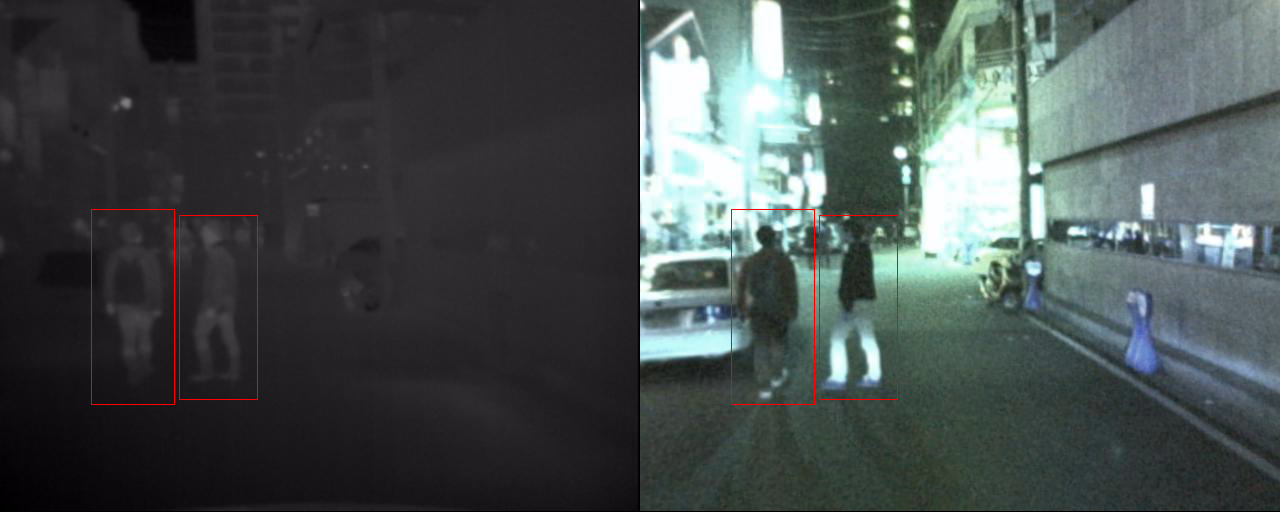

In [13]:

# K-means 클러스터링을 통한 새로운 앵커 설정
new_anchors = kmean_anchors(train_loader.dataset, n=9, img_size=imgsz, thr=4.0, gen=1000)
new_anchors = new_anchors.reshape(-1, 2)
print("New Anchors:", new_anchors)

# 새로운 앵커 설정 적용
hyp['anchors'] = new_anchors.tolist()

# 새로운 앵커로 모델 초기화
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [27]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)
# K-means 클러스터링을 통한 새로운 앵커 설정
new_anchors = kmean_anchors(train_loader.dataset, n=9, img_size=imgsz, thr=4.0, gen=1000)
new_anchors = new_anchors.reshape(-1, 2)
print("New Anchors:", new_anchors)

# 새로운 앵커 설정 적용
hyp['anchors'] = new_anchors.tolist()

# 새로운 앵커로 모델 초기화
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)

train: Scanning /home/sub/kaist-rgbt/train.cache... 10030 images, 5641 backgrounds, 0 corrupt: 100%|██████████| 10030/10030 [00:00<?, ?it/s]


NameError: name 'kmean_anchors' is not defined

In [15]:
import numpy as np
import cv2
from PIL import Image
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112

# 빠르게 미니배치 가져오기
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # 정규화된 bbox를 픽셀 좌표로 변환
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[int(c)]
        cv2.rectangle(img_lwir, tuple(bb[:2]), tuple(bb[2:]), color, 2)
        cv2.rectangle(img_vis,  tuple(bb[:2]), tuple(bb[2:]), color, 2)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])



IndexError: index 12112 is out of bounds for axis 0 with size 10030

## Run trained model
- Visualize bounding boxes from dataset class

In [24]:
import torch
from models.yolo import Model
import random
from utils.torch_utils import select_device
import torch
import cv2
import numpy as np
from PIL import Image
from utils.general import scale_boxes, non_max_suppression, plot_one_box

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

ImportError: cannot import name 'plot_one_box' from 'utils.general' (/home/sub/aue8088-pa2/utils/general.py)

In [22]:
conf_thres = 0.25  # 신뢰도 임계값
iou_thres = 0.45  # NMS IOU 임계값
max_det = 1000  # 이미지당 최대 탐지 수
classes = None
agnostic_nms = False  # 클래스 무관 NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# 예측 박스 크기 조정 및 이미지에 그리기
colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 0, 255)}

for i, det in enumerate(pred):
    img_lwir = imgs[0][i].cpu().numpy().transpose((1, 2, 0)) * 255
    img_vis = imgs[1][i].cpu().numpy().transpose((1, 2, 0)) * 255
    img_lwir = img_lwir.astype(np.uint8)
    img_vis = img_vis.astype(np.uint8)

    if len(det):
        det[:, :4] = scale_boxes(imgs[i].shape[1:], det[:, :4], shapes[i][0])

        for *xyxy, conf, cls in det:
            label = f'{model.names[int(cls)]} {conf:.2f}'
            plot_one_box(xyxy, img_lwir, label=label, color=colors[int(cls)], line_thickness=2)
            plot_one_box(xyxy, img_vis, label=label, color=colors[int(cls)], line_thickness=2)

    images = np.concatenate([img_lwir, img_vis], axis=1)
    img = Image.fromarray(images)
    img.show()

def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # 한 개의 바운딩 박스를 이미지에 그립니다.
    tl = line_thickness or round(0.002 * max(img.shape[0:2]))  # 라인/폰트 두께
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # 폰트 두께
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # 채우기
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

NameError: name 'pred' is not defined

In [27]:
pred[0]

tensor([], size=(0, 6))